In [5]:
# 📌 STEP 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [6]:

# 📦 STEP 2: Install required packages
!pip install prophet xgboost openpyxl tensorflow --quiet


In [7]:
# 📚 STEP 3: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import warnings
warnings.filterwarnings("ignore")

In [8]:

# 📁 STEP 4: Load Excel file from Google Drive
file_path = '/content/drive/MyDrive/graduation project/stocks/EGX100_20090802_20190827 (1).xls'  # 📄 Update path if needed
df = pd.read_excel(file_path)

In [9]:

# 🧹 STEP 5: Prepare time series
df['INDEXDATE'] = pd.to_datetime(df['INDEXDATE'])
df.set_index('INDEXDATE', inplace=True)
ts = df['INDEXCLOSE'].astype(float)

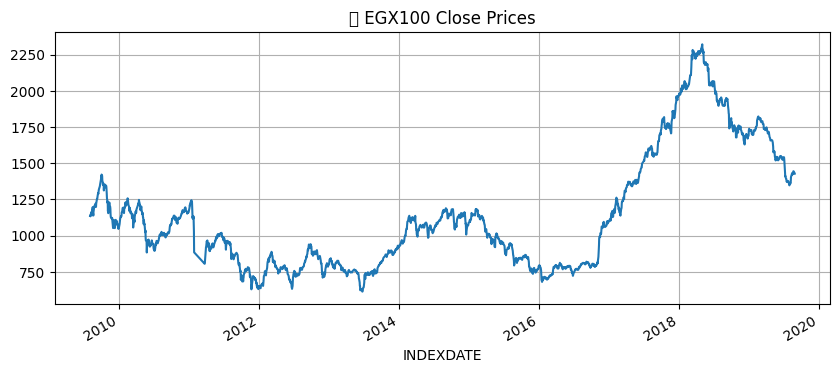

In [10]:
# 📈 Plot the time series
ts.plot(title='📉 EGX100 Close Prices', figsize=(10, 4))
plt.grid()
plt.show()


In [11]:
# 🧪 STEP 6: Train-test split
train_size = int(len(ts) * 0.8)
train, test = ts[:train_size], ts[train_size:]


In [12]:

# 📊 STEP 7: Define evaluation function
def evaluate(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    nmae = mae / np.mean(np.abs(y_true))
    var = np.var(y_pred)
    return {'MAE': mae, 'RMSE': rmse, 'nMAE': nmae, 'Variance': var}

results = {}
predictions = {}


In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
from prophet import Prophet

# 🔮 Prophet Model
prophet_df = ts.reset_index().rename(columns={'INDEXDATE': 'ds', 'INDEXCLOSE': 'y'})
model = Prophet()
model.fit(prophet_df.iloc[:train_size])
future = model.make_future_dataframe(periods=len(test))
forecast = model.predict(future)
prophet_pred = forecast['yhat'].values[-len(test):]

# 📈 Evaluation
mae_prophet = mean_absolute_error(test, prophet_pred)
rmse_prophet = np.sqrt(mean_squared_error(test, prophet_pred))
nmae_prophet = mae_prophet / np.mean(test)
variance_prophet = np.var(prophet_pred)
nrmse_minmax_prophet = rmse_prophet / (test.max() - test.min())
nrmse_mean_prophet = rmse_prophet / np.mean(test)

# Store results
results['🧙‍♂️ Prophet'] = {
    'MAE': mae_prophet,
    'RMSE': rmse_prophet,
    'nMAE': nmae_prophet,
    'Variance': variance_prophet,
    'NRMSE_minmax': nrmse_minmax_prophet,
    'NRMSE_mean': nrmse_mean_prophet
}
predictions['🧙‍♂️ Prophet'] = prophet_pred


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqyoyqygm/l64g3p1u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqyoyqygm/qk_h4ms2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64337', 'data', 'file=/tmp/tmpqyoyqygm/l64g3p1u.json', 'init=/tmp/tmpqyoyqygm/qk_h4ms2.json', 'output', 'file=/tmp/tmpqyoyqygm/prophet_model5ubiraz6/prophet_model-20250526230726.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:07:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:07:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [14]:
# 🔁 ARIMA Model
arima_model = ARIMA(train, order=(5,1,0))
arima_fit = arima_model.fit()
arima_pred = arima_fit.forecast(steps=len(test))

# 📈 Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

mae_arima = mean_absolute_error(test, arima_pred)
rmse_arima = np.sqrt(mean_squared_error(test, arima_pred))
nmae_arima = mae_arima / np.mean(test)
variance_arima = np.var(arima_pred)
nrmse_minmax_arima = rmse_arima / (test.max() - test.min())
nrmse_mean_arima = rmse_arima / np.mean(test)

# Store results
results['🔁 ARIMA'] = {
    'MAE': mae_arima,
    'RMSE': rmse_arima,
    'nMAE': nmae_arima,
    'Variance': variance_arima,
    'NRMSE_minmax': nrmse_minmax_arima,
    'NRMSE_mean': nrmse_mean_arima
}
predictions['🔁 ARIMA'] = arima_pred


In [15]:
# 🌀 SARIMA Model
sarima_model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,12))
sarima_fit = sarima_model.fit()
sarima_pred = sarima_fit.forecast(steps=len(test))

# 📈 Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

mae_sarima = mean_absolute_error(test, sarima_pred)
rmse_sarima = np.sqrt(mean_squared_error(test, sarima_pred))
nmae_sarima = mae_sarima / np.mean(test)
variance_sarima = np.var(sarima_pred)
nrmse_minmax_sarima = rmse_sarima / (test.max() - test.min())
nrmse_mean_sarima = rmse_sarima / np.mean(test)

# Store results
results['🌀 SARIMA'] = {
    'MAE': mae_sarima,
    'RMSE': rmse_sarima,
    'nMAE': nmae_sarima,
    'Variance': variance_sarima,
    'NRMSE_minmax': nrmse_minmax_sarima,
    'NRMSE_mean': nrmse_mean_sarima
}
predictions['🌀 SARIMA'] = sarima_pred


In [16]:
# 🚀 XGBoost Model
window = 10
X, y = [], []
for i in range(len(train) - window):
    X.append(train.values[i:i+window])
    y.append(train.values[i+window])

X_test = [test.values[i:i+window] for i in range(len(test) - window)]
y_test = test.values[window:]

model_xgb = XGBRegressor()
model_xgb.fit(X, y)
xgb_pred = model_xgb.predict(X_test)

# 📈 Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

mae_xgb = mean_absolute_error(y_test, xgb_pred)
rmse_xgb = np.sqrt(mean_squared_error(y_test, xgb_pred))
nmae_xgb = mae_xgb / np.mean(y_test)
nrmse_minmax_xgb = rmse_xgb / (y_test.max() - y_test.min())
nrmse_mean_xgb = rmse_xgb / np.mean(y_test)
variance_xgb = np.var(xgb_pred)

# Store results
results['🚀 XGBoost'] = {
    'MAE': mae_xgb,
    'RMSE': rmse_xgb,
    'nMAE': nmae_xgb,
    'Variance': variance_xgb,
    'NRMSE_minmax': nrmse_minmax_xgb,
    'NRMSE_mean': nrmse_mean_xgb
}
predictions['🚀 XGBoost'] = xgb_pred

# Optional: print metrics
for metric, value in results['🚀 XGBoost'].items():
    print(f"{metric}: {value:.6f}")


MAE: 273.683467
RMSE: 341.476623
nMAE: 0.149880
Variance: 1710.944336
NRMSE_minmax: 0.350826
NRMSE_mean: 0.187007


In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# 🧠 LSTM Model
scaler = MinMaxScaler(feature_range=(0, 1))  # ensure scaling is 0 to 1
scaled_train = scaler.fit_transform(train.values.reshape(-1, 1))

X_lstm, y_lstm = [], []
for i in range(window, len(scaled_train)):
    X_lstm.append(scaled_train[i-window:i])
    y_lstm.append(scaled_train[i])
X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)

model_lstm = Sequential()
model_lstm.add(LSTM(50, return_sequences=False, input_shape=(X_lstm.shape[1], 1)))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='rmsprop', loss='mse')  # Changed optimizer
model_lstm.fit(X_lstm, y_lstm, epochs=50, batch_size=35, verbose=0)

# 📊 Prepare test data for LSTM (normalized)
scaled_full = scaler.transform(ts.values.reshape(-1, 1))
X_test_lstm = []
for i in range(train_size, len(ts) - window):
    X_test_lstm.append(scaled_full[i-window:i])
X_test_lstm = np.array(X_test_lstm)

# 🧠 LSTM Predictions
lstm_pred = model_lstm.predict(X_test_lstm).flatten()

# 📈 Evaluation in normalized scale
actual = scaled_full[train_size + window:].flatten()

mae = mean_absolute_error(actual, lstm_pred)
rmse = np.sqrt(mean_squared_error(actual, lstm_pred))
nmae = mae / np.mean(actual)
variance = np.var(lstm_pred)
nrmse_minmax = rmse / (actual.max() - actual.min())
nrmse_mean = rmse / np.mean(actual)

results['🧠 LSTM'] = {
    'MAE': mae,
    'RMSE': rmse,
    'nMAE': nmae,
    'Variance': variance,
    'NRMSE_minmax': nrmse_minmax,
    'NRMSE_mean': nrmse_mean
}
predictions['🧠 LSTM'] = lstm_pred


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


In [18]:
# 🏁 Display Final Results Table with styling
results_df = pd.DataFrame(results).T

styled_results = results_df.style\
    .background_gradient(cmap='YlGnBu', axis=None)\
    .set_caption("📊 Final Evaluation Metrics for Time Series Models")\
    .set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#0d6efd'), ('color', 'white'), ('font-size', '14px')]},
        {'selector': 'caption', 'props': [('caption-side', 'top'), ('font-size', '16px'), ('font-weight', 'bold')]},
        {'selector': 'td', 'props': [('font-size', '13px')]}
    ])\
    .format("{:.4f}")

display(styled_results)

,MAE,RMSE,nMAE,Variance,NRMSE_minmax,NRMSE_mean
🧙‍♂️ Prophet,327.5768,381.4624,0.1799,44159.0565,0.3919,0.2095
🔁 ARIMA,300.4312,363.6481,0.1650,0.0274,0.3736,0.1997
🌀 SARIMA,266.6236,330.7715,0.1465,1656.3729,0.3398,0.1817
🚀 XGBoost,273.6835,341.4766,0.1499,1710.9443,0.3508,0.1870
🧠 LSTM,0.0592,0.0755,0.0491,0.0486,0.0780,0.0626


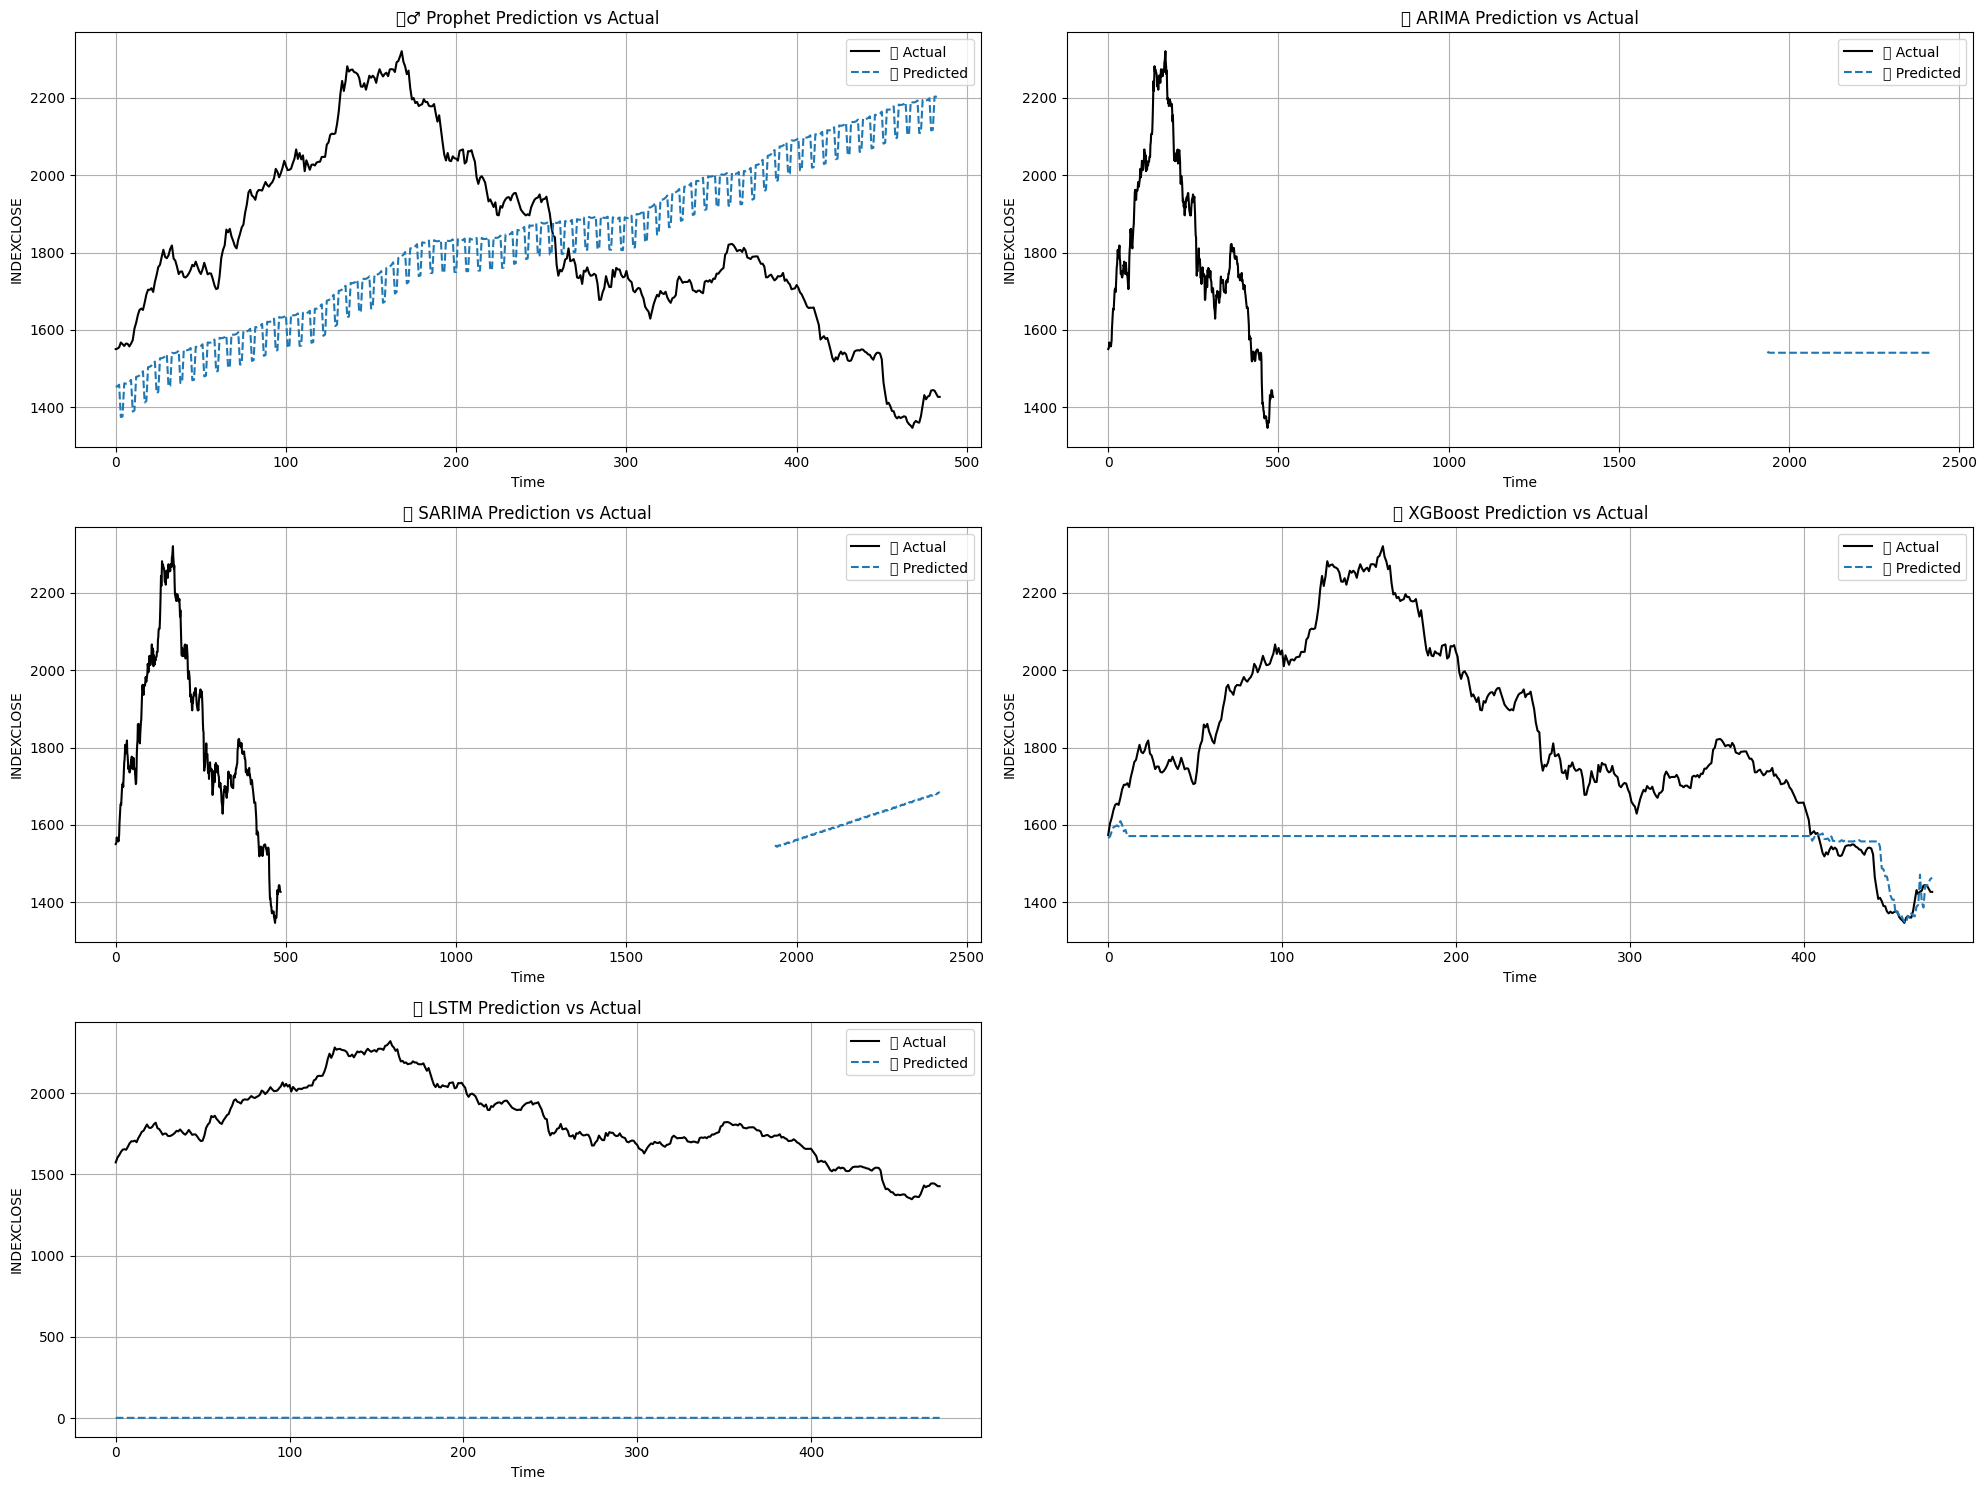

In [19]:

# 📈 Plot Actual vs Predicted for all models
plt.figure(figsize=(20, 15))
for i, (model_name, pred) in enumerate(predictions.items(), 1):
    plt.subplot(3, 2, i)
    if model_name in ['🧠 LSTM', '🚀 XGBoost']:
        actual_plot = test.values[window:]
    else:
        actual_plot = test.values
    plt.plot(actual_plot, label='📈 Actual', color='black')
    plt.plot(pred, label='🔮 Predicted', linestyle='--')
    plt.title(f'{model_name} Prediction vs Actual')
    plt.xlabel("Time")
    plt.ylabel("INDEXCLOSE")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


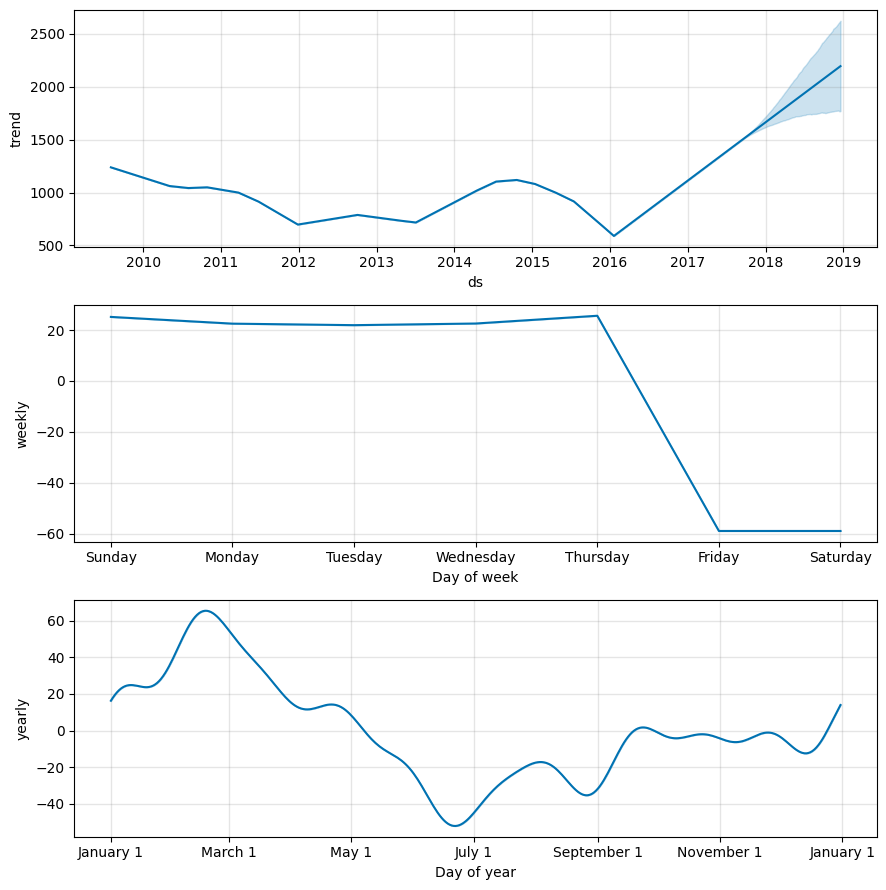

   additive_terms  additive_terms_lower  additive_terms_upper     weekly  \
0        7.942927              7.942927              7.942927  25.170137   
1        5.394043              5.394043              5.394043  22.524311   
2        4.783225              4.783225              4.783225  21.928543   
3        5.293847              5.293847              5.293847  22.574254   
4        8.080249              8.080249              8.080249  25.621970   
5        6.060975              6.060975              6.060975  25.170137   
6        2.636777              2.636777              2.636777  22.524311   
7        1.145034              1.145034              1.145034  21.928543   
8        0.788184              0.788184              0.788184  22.574254   
9        2.740940              2.740940              2.740940  25.621970   

   weekly_lower  weekly_upper     yearly  yearly_lower  yearly_upper  \
0     25.170137     25.170137 -17.227210    -17.227210    -17.227210   
1     22.524311    

In [20]:
# Assuming prophet model is already fit as in your code

# Get seasonal components from Prophet
seasonality = model.predict_seasonal_components(prophet_df)

# Plot seasonality components
model.plot_components(forecast)
plt.show()

# To see numeric seasonal values for the forecast period:
print(seasonality.head(10))
